In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

import nc_time_axis
import cftime
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cmocean import cm as cmo

import gsw
from GG_mthesis import utils as utils

%matplotlib inline

In [2]:
import os
os.chdir('C:\\Users\\gian_\\repos\\mthesis_gianlucca')
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [3]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')

In [4]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_transect.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

Let's define the new variables I am going to work with. We have decided to use the tsg temperature and salinity, so that is what I am going to use, the rest can be dropped

In [5]:
#I define the (same) temperature and practical salinity variable 
ds['temperature'] = ds.temp_cond_tsg
ds['SP'] = ds.sal_tsg_cal

#I calculate the pressure from the depth
ds['pressure'] = gsw.p_from_z(-ds.depth, ds.lat)

#With the SP, pressure and coordinates I can calculate the absolute salinity
ds['SA'] = gsw.SA_from_SP(ds.SP, ds.pressure, ds.lon, ds.lat)

#With SA, temperature and p, I can calculate the conservative temperature.
ds['CT'] = gsw.CT_from_t(ds.SA, ds.temperature, ds.pressure)

#Attributes for the new variables
ds['pressure'].attrs={'long name':'pressure', 'units':'dbar', 'description':'sea pressure from height using gsw'}

ds['SA'].attrs={'long name':'Absolute salinity', ' units':'g/kg', 'description':'Absolute salinity calculated from practical salinity using gsw'}

#Let´s drop everything that is not used anymore
ds = ds.drop(['attenuation','conductivity_tsg','chl-a','sal_tsg_cal','sal_tsg_nocal','temp_hull_1','temp_hull_2','temp_cond_tsg'])

[Text(0, 0.5, 'Salinity')]

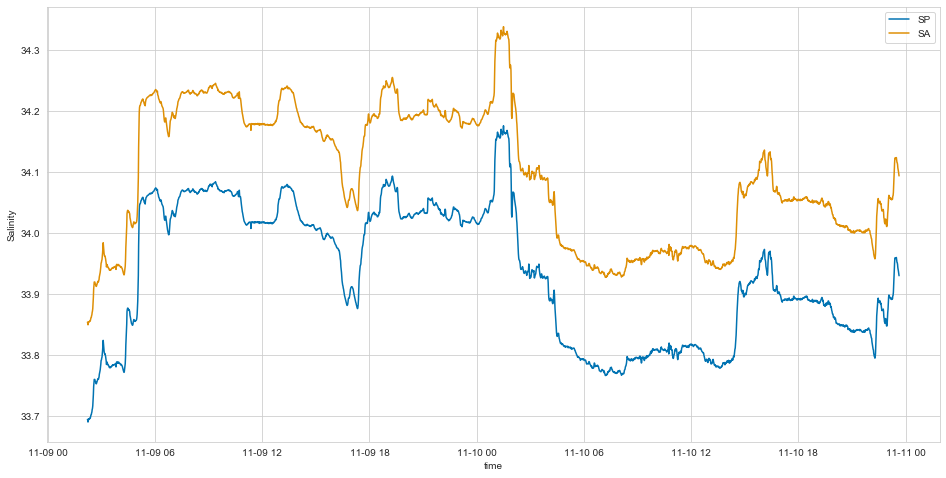

In [6]:
fig, ax0 = plt.subplots(figsize=(16,8))

sns.lineplot(x=ds.time, y=ds.SP, label='SP')
sns.lineplot(x=ds.time, y=ds.SA, label='SA')

ax0.set(ylabel='Salinity')

Now we can calculate the density

In [7]:
#In-situ density
ds['rho'] = gsw.rho(ds.SA, ds.CT, ds.pressure)

#potential density (shouldn't make a bit difference when taking the gradient)
ds['rho_pot'] = gsw.rho(ds.SA, ds.CT, 0)

[Text(0, 0.5, 'Density (kg m^-3)')]

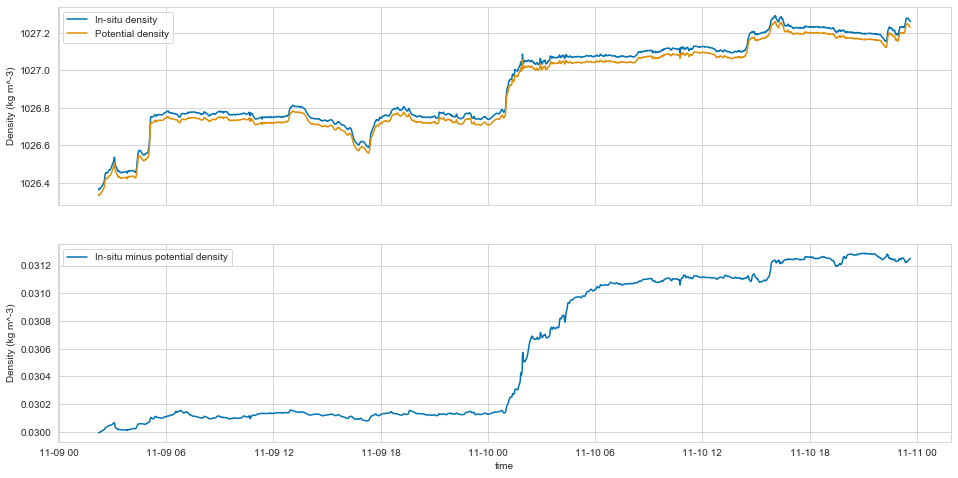

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,8))

sns.lineplot(x=ds.time, y=ds.rho, ax=ax0, label='In-situ density')
sns.lineplot(x=ds.time, y=ds.rho_pot, ax=ax0, label='Potential density')

sns.lineplot(x=ds.time, y=ds.rho - ds.rho_pot, ax=ax1, label = 'In-situ minus potential density')

ax0.set(ylabel='Density (kg m^-3)')
ax1.set(ylabel='Density (kg m^-3)')

In [9]:
#Let's calculate the distances
distance = []
for coord in range(len(ds.lat)-1):
    distance.append(utils.geo.getPathLength(ds.lat[coord],ds.lon[coord],ds.lat[coord+1],ds.lon[coord+1]))
distance = np.array(distance)

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance), 0, 0)

ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})

In [10]:
#let's calculate the density gradient (I am going to use the in-situ density)
rho_diff = []
for point in range(len(ds.rho)-1):
    rho_diff.append((ds.rho[point]-ds.rho[point+1])/distance[point])
rho_diff = np.array(rho_diff)

ds['rho_diff'] = xr.DataArray(rho_diff,dims={'distance':distance},coords={'distance':distance})

In [11]:
rho_diff_extend = np.insert(ds.rho_diff, 0, np.median(ds.rho_diff))

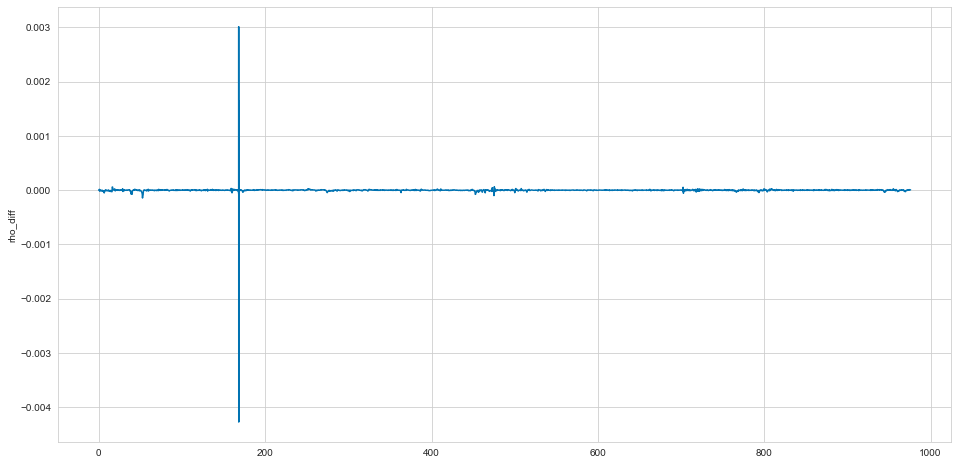

In [12]:
fig, ax0 = plt.subplots(figsize=(16,8))

sns.lineplot(x=distance_cum/1000,y=rho_diff_extend)

#here we can see that it definitly has to be gridded